# MNIST in Sklearn

## 데이터 준비

In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)


In [2]:
import sklearn
sklearn.__version__

'0.24.1'

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
x, y = mnist["data"], mnist["target"]
x.shape

(70000, 784)

In [5]:
y.shape

(70000,)

pandas형태로 되어있는 x, y를 numpy 배열로 바꾸어준다.

In [6]:
x = x.to_numpy()
y = y.to_numpy()

In [7]:
x[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [8]:
x[0].shape

(784,)

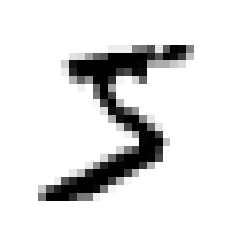

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [10]:
y = y.astype(np.uint8)

In [11]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [12]:
X_train, X_test, Y_train, Y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [13]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
some_digit.shape

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

## 이진 분류기

지금 작성할 5 감지기는 '5' 또는 '5가 아님' 두 가지의 클래스를 구분 할 수 있는 "이진 분류기"의 한 예입니다.
분류 작업을 위해 타깃 벡터를 만들어 보자.

In [15]:
Y_train_5 = (Y_train == 5)
Y_test_5 = (Y_test == 5)

SGDClassifier은 확률적 경사하강법이다.

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, Y_train_5)

SGDClassifier(random_state=42)

In [19]:
some_digit.shape

(784,)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차 검증을 이용한 정확도 측정

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, Y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, Y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    Y_train_folds = Y_train_5[train_index]
    X_test_fold = X_train[test_index]
    Y_test_fold = Y_train_5[test_index]

    clone_clf.fit(X_train_folds, Y_train_folds)
    Y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(Y_pred == Y_test_fold)
    print(n_correct / len(Y_pred))

0.9669
0.91625
0.96785


In [34]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [37]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, Y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90%이상으로 나온다.
이 예제는 정확도를 성능측정지표로 선호하지 않는 이유를 보여준다.
특히 불균형한 데이터셋을 다룰때, 즉, 어떤 클래스가 다른 것보다 월등히 많은 경우)

### 오차 행렬

In [39]:
from sklearn.model_selection import cross_val_predict
Y_train_pred = cross_val_predict(sgd_clf, X_train, Y_train_5, cv = 3)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train_5, Y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [44]:
from sklearn.metrics import precision_score, recall_score

precision_score(Y_train_5, Y_train_pred)

0.8370879772350012

In [45]:
recall_score(Y_train_5, Y_train_pred)

0.6511713705958311

생각보다 정확도로 점수를 매겼을 때보다 좋지 않은 점수가 나온다.
F1점수로 한번 매겨보자. F1점수는 정밀도와 재현율의 조회평균이다.

In [46]:
from sklearn.metrics import f1_score

f1_score(Y_train_5, Y_train_pred)

0.7325171197343846

F1점수가 정밀도와 재현율의 조화 평균이라 해서 무조건적으로 좋은 것은 아니다.
정밀도 또는 재현율 둘 중 하나가 더 중요한 경우도있으며 이 둘 모두 얻을 수는 없다.
그래서 정밀도가 중요하면 정밀도를 올리는대신 재현율이 떨어진다. 그 반대의 경우도 그렇다.
이를 정밀도 재현율 트레이드오프라고 한다.

In [47]:
Y_scores = sgd_clf.decision_function([some_digit])
Y_scores

array([2164.22030239])

In [49]:
threshold = 0
Y_some_digit_pred = (Y_scores > threshold)
Y_some_digit_pred

array([ True])

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, Y_train_5, cv=3, method="decision_function")

In [56]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Y_train_5, y_scores)

In [57]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g--', label="Recalls", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.grid(True)
    

SyntaxError: invalid syntax (<ipython-input-57-fd35d53178ce>, line 4)